In [1]:
import numpy as np
from scipy.signal import convolve2d
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train)
y_test_onehot = one_hot(y_test)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def avg_pool2d(x, pool_size=(2, 2)):
    n, h, w, c = x.shape
    h_out = h // pool_size[0]
    w_out = w // pool_size[1]
    pooled = np.zeros((n, h_out, w_out, c))

    for i in range(h_out):
        for j in range(w_out):
            h_start = i * pool_size[0]
            h_end = h_start + pool_size[0]
            w_start = j * pool_size[1]
            w_end = w_start + pool_size[1]
            pooled[:, i, j, :] = np.mean(x[:, h_start:h_end, w_start:w_end, :], axis=(1, 2))
    return pooled

def cross_entropy_loss(y_true, y_pred):
    return -np.mean(y_true * np.log(y_pred + 1e-10))

def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true


In [18]:
from scipy.signal import correlate2d, convolve2d

class ConvLayer:
    def __init__(self, num_filters, filter_size, input_channels, padding=0):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(filter_size, filter_size, input_channels, num_filters) * 0.1
        self.padding = padding

    def forward(self, input):
        self.input = input
        if self.padding > 0:
            input_padded = np.pad(input, ((0, 0), (self.padding, self.padding),
                                      (self.padding, self.padding), (0, 0)), mode='constant')
        else:
            input_padded = input

        n, h, w, _ = input_padded.shape
        output_h = h - self.filter_size + 1
        output_w = w - self.filter_size + 1
        output = np.zeros((n, output_h, output_w, self.num_filters))

        for i in range(n):
            for f in range(self.num_filters):
                for c in range(self.input.shape[-1]):
                    output[i, :, :, f] += correlate2d(input_padded[i, :, :, c],
                                                    self.filters[:, :, c, f], mode='valid')
        return tanh(output)

    def backward(self, dL_dout, learning_rate):
        n = self.input.shape[0]
        dL_dinput = np.zeros_like(self.input)
        dL_dfilters = np.zeros_like(self.filters)

        # Добавляем padding для градиента по входу
        if self.padding > 0:
            pad_width = [(0, 0), (self.padding, self.padding),
                         (self.padding, self.padding), (0, 0)]
            input_padded = np.pad(self.input, pad_width, mode='constant')
            dL_dinput_padded = np.pad(dL_dinput, pad_width, mode='constant')
        else:
            input_padded = self.input
            dL_dinput_padded = dL_dinput

        for i in range(n):
            for f in range(self.num_filters):
                for c in range(self.input.shape[-1]):
                    # Градиент по фильтрам
                    dL_dfilters[:, :, c, f] += correlate2d(input_padded[i, :, :, c],
                                                         dL_dout[i, :, :, f], mode='valid')

                    # Градиент по входу (используем полную свертку)
                    grad = convolve2d(dL_dout[i, :, :, f],
                                    self.filters[:, :, c, f], mode='full')

                    # Обрезаем или добавляем к градиенту
                    if self.padding > 0:
                        h, w = grad.shape
                        h_in, w_in = dL_dinput_padded.shape[1:3]
                        h_start = (h - h_in) // 2
                        w_start = (w - w_in) // 2
                        dL_dinput_padded[i, :, :, c] += grad[h_start:h_start+h_in, w_start:w_start+w_in]
                    else:
                        dL_dinput_padded[i, :, :, c] += grad

        # Если был padding, обрезаем градиент
        if self.padding > 0:
            dL_dinput = dL_dinput_padded[:, self.padding:-self.padding,
                                        self.padding:-self.padding, :]
        else:
            dL_dinput = dL_dinput_padded

        # Обновление весов
        self.filters -= learning_rate * dL_dfilters / n

        # Умножаем на производную tanh
        return dL_dinput * tanh_derivative(self.input)

# Полносвязный слой
class FCLayer:
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.1
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, dL_dout, learning_rate):
        dL_dinput = np.dot(dL_dout, self.weights.T)
        dL_dweights = np.dot(self.input.T, dL_dout)
        dL_dbias = np.sum(dL_dout, axis=0, keepdims=True)

        # Обновление весов
        self.weights -= learning_rate * dL_dweights / len(self.input)
        self.bias -= learning_rate * dL_dbias / len(self.input)
        return dL_dinput

class LeNet5:
    fc1_out = None
    fc2_out = None
    def __init__(self, batch_size = 128, learning_rate = 0.01, epochs = 5):
        self.conv1 = ConvLayer(6, 5, 1, padding=2)
        self.conv2 = ConvLayer(16, 5, 6)
        self.fc1 = FCLayer(16*5*5, 120)
        self.fc2 = FCLayer(120, 84)
        self.fc3 = FCLayer(84, 10)

        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs

    def forward(self, x):
        x = self.conv1.forward(x)
        x = avg_pool2d(x, (2, 2))
        x = self.conv2.forward(x)
        x = avg_pool2d(x, (2, 2))
        x = x.reshape(x.shape[0], -1)
        self.fc1_out = self.fc1.forward(x)
        x = tanh(self.fc1_out)
        self.fc2_out = self.fc2.forward(x)
        x = tanh(self.fc2_out)
        x = softmax(self.fc3.forward(x))
        return x

    def backward(self, dL_dout, learning_rate):
        dL_dout = self.fc3.backward(dL_dout, learning_rate)
        dL_dout = dL_dout * tanh_derivative(self.fc2_out)
        dL_dout = self.fc2.backward(dL_dout, learning_rate)
        dL_dout = dL_dout * tanh_derivative(self.fc1_out)
        dL_dout = self.fc1.backward(dL_dout, learning_rate)

        dL_dout = dL_dout.reshape(-1, 5, 5, 16)

        dL_dout = np.repeat(np.repeat(dL_dout, 2, axis=1), 2, axis=2) / 4

        dL_dout = self.conv2.backward(dL_dout, learning_rate)

        dL_dout = np.repeat(np.repeat(dL_dout, 2, axis=1), 2, axis=2) / 4

        _ = self.conv1.backward(dL_dout, learning_rate)

    def fit(self):
      for epoch in range(self.epochs):
          epoch_loss = 0
          correct = 0

          for i in range(0, len(X_train), self.batch_size):
              X_batch = X_train[i:i+self.batch_size]
              y_batch = y_train_onehot[i:i+self.batch_size]

              y_pred = self.forward(X_batch)
              loss = cross_entropy_loss(y_batch, y_pred)
              epoch_loss += loss

              correct += np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))

              dL_dout = cross_entropy_derivative(y_batch, y_pred)
              self.backward(dL_dout, self.learning_rate)

          train_acc = correct / len(X_train)
          print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.4f}")

Epoch 1/5, Loss: 59.3354, Accuracy: 0.6798
Epoch 2/5, Loss: 24.5867, Accuracy: 0.8700
Epoch 3/5, Loss: 18.2015, Accuracy: 0.8967
Epoch 4/5, Loss: 15.2600, Accuracy: 0.9100
Epoch 5/5, Loss: 13.3911, Accuracy: 0.9200
Test Accuracy: 0.9270


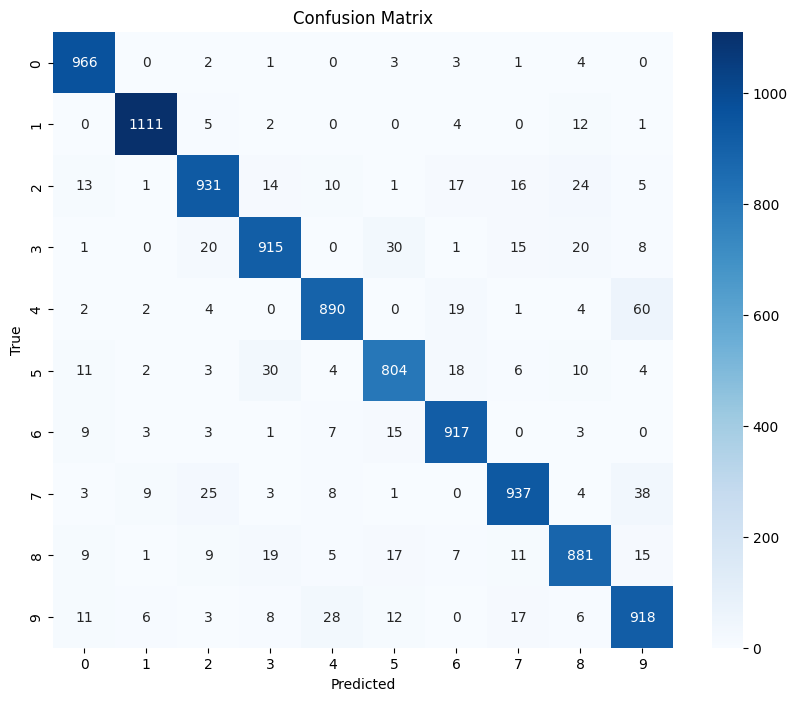

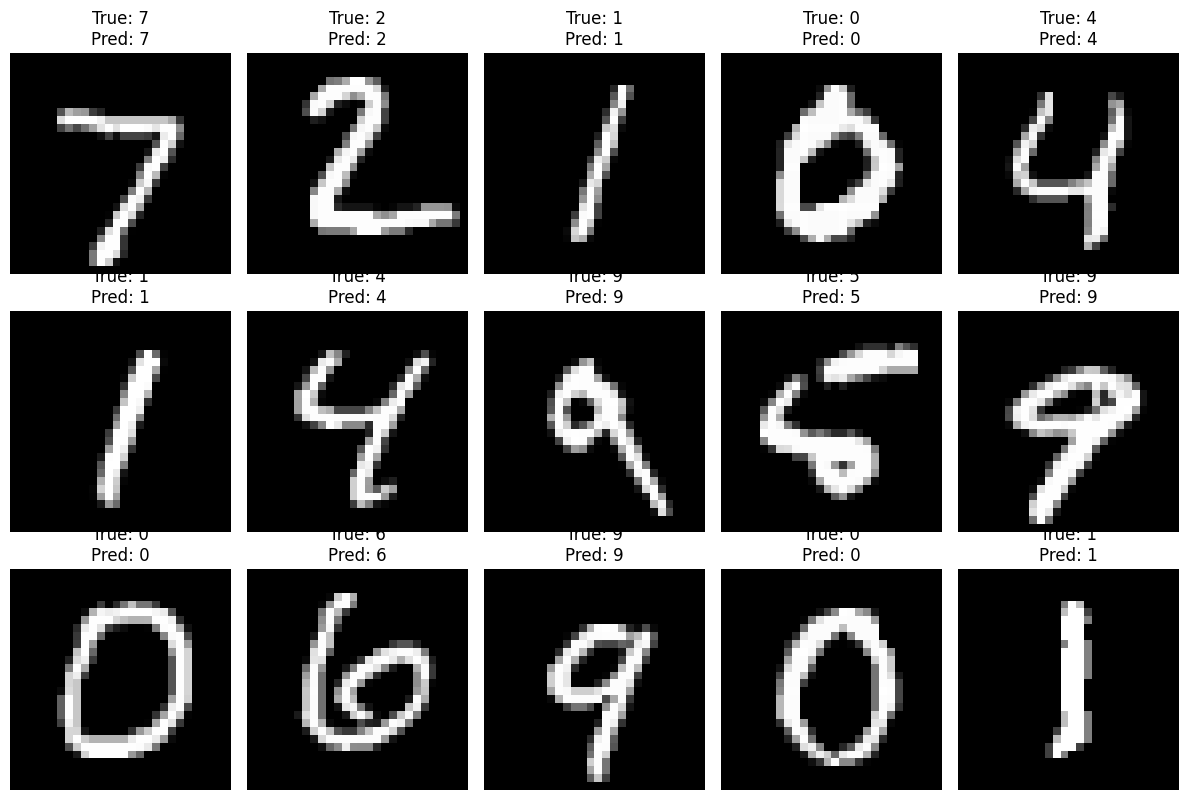

In [19]:

model = LeNet5(batch_size = 128, learning_rate=0.01, epochs=5)
model.fit()

y_test_pred = model.forward(X_test)
test_acc = np.mean(np.argmax(y_test_pred, axis=1) == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_classes = np.argmax(y_test_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].squeeze(), cmap='gray')
    ax.set_title(f"True: {y_test[i]}\nPred: {y_pred_classes[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()